# Piecewise linear kernel density estimation

We will approximate the density of our distribution by a piecewise linear distribution on the interval $[a,b]$, with node points $z_i, i=0\ldots N$.

The height at each node point is given by: 
$$h_i=e^{q_i} / M(\vec{q}), i=1\ldots N $$
$$h_0=1/M(\vec{q})$$

We use this parameterization because `scipy`'s optimization methods work better unconstrained, and any value $\vec{q} \in \mathbb{R}^{N+1}$ is valid.

$$ M(\vec{q}) = \int_a^b p(x) dx = \sum_{i=1}^N \frac{1}{2} (e^{q_i}+e^{q_{i-1}})(z_i-z_{i-1})$$


Holding the node points $z_i$ fixed, let us calculate $\nabla_q h_i$. This will be necessary to do gradient ascent and find a max likelihood/max aposteriori parametric curve given data.

Preliminary calculations:

$$ \frac{\partial M(\vec{q})}{\partial_{q_j}} = e^{q_j}(z_j-z_{j-1}) + e^{q_j}(z_{j+1}-z_j) = e^{q_j} (z_{j+1}-z_{j-1}), j=1\ldots N-1$$

$$ \frac{\partial M(\vec{q})}{\partial_{q_N}} = \frac{1}{2} e^{q_N}(z_N-z_{N-1}) $$

We can then use this to calculate $\frac{\partial h_i(\vec{q})}{\partial_{q_j}}$.

$$ \frac{\partial h_i(\vec{q})}{\partial_{q_j}}  = \frac{e^{q_i} \delta_{ij}}{M(\vec{q})} - \frac{e^{q_i} e^{q_j}(z_{j+1}-z_{j-1})}{M(\vec{q})^2} , j > 1$$
$$ = e^{q_i} \left(\frac{\delta_{ij} M(\vec{q}) - e^{q_j} (z_{j+1}-z_{j-1}) }{M(\vec{q})^2} \right) $$
and
$$ \frac{\partial h_0(\vec{q})}{\partial_{q_j}} = \frac{-1}{2 M(\vec{q})^2}  \frac{\partial M(\vec{q})}{\partial_{q_j}} $$

[[-0.10906815 -0.07311056 -0.09868894 -0.17982297 -0.04067764]
 [ 0.7683937  -0.12053894 -0.16271055 -0.29647796 -0.13413217]
 [-0.12053894  0.55480897 -0.10906815 -0.19873512 -0.08991149]
 [-0.16271055 -0.10906815  0.71075533 -0.26826435 -0.12136781]
 [-0.29647796 -0.19873512 -0.26826435  1.07453548 -0.22114657]
 [-0.26826435 -0.17982297 -0.24273562 -0.44229314  1.21447136]]


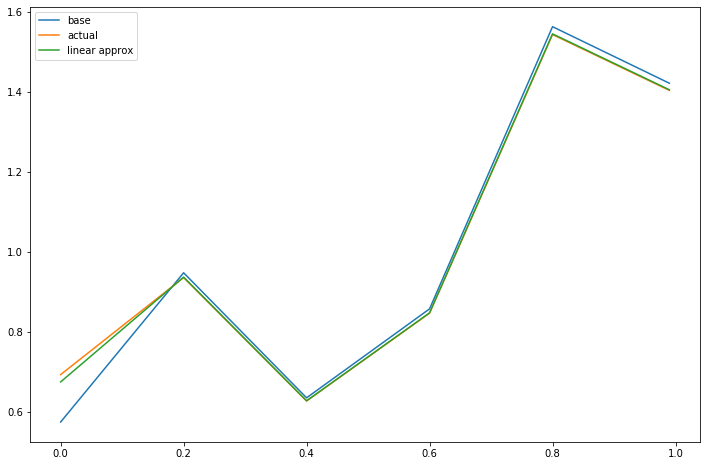

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 8

dz = 0.1
zz = np.arange(0, 1+dz, dz)

class PiecewiseLinearKDE:
    def __init__(self, nodes, q):
        nodes = np.array(nodes)
        q = np.array(q)
        assert len(nodes) == len(q)+1, "One more node than parameters"
        assert (nodes[0:-1] < nodes[1:]).all(), "Nodes must all be in order."
        self.nodes = nodes
        self.__interval_size = nodes[1:]-nodes[:-1]
        self.N = len(nodes)-1
        self.volume_ = self.nodes[-1] - self.nodes[0]
        self.q = q

    def M(self):
        exq = self._exp_q()
        return (0.5*(exq[1:]+exq[:-1])*self.__interval_size).sum()
    
    def h(self):
        return  self._exp_q() / self.M()
    
    def _exp_q(self):
        result = np.ones(shape=(self.N+1,))
        result[1:] = np.exp(self.q)
        return result
    
    def grad_h(self):
        mm = self.M()
        mm2 = mm*mm
        exq = self._exp_q()
        
        z_diff = np.zeros(shape=(self.N+1))
        z_diff[:-1] += self.nodes[1:]
        z_diff[1:] -= self.nodes[:-1]
        z_diff[-1] = self.nodes[-1] - self.nodes[-2]
        
        result = np.zeros(shape=(self.N+1, self.N), dtype=float)
        
        result[0,:] = (- 0.5 / mm2) * np.exp(self.q) * z_diff[1:]
        #result[0,:] *= z_diff[1:]
        result[0,-1] /= 2        
        
        for i in range(1,self.N+1):  # Add the diagonal term
            result[i,i-1] += exq[i]/mm
            result[i,:] -= 0.5*exq[i]*exq[1:]*z_diff[1:] / mm2
        return result#.transpose()
    
    def grad_x(self, dq, x):
        """
        This function calculates 
        """
        return np.interp(x, self.nodes, self.grad_h() @ dq)
    
    def grad_q(self, x):
        result = np.zeros(shape=(self.N, len(x)))
        gh = self.grad_h()
        for i in range(self.N):
            result[i,:] = np.interp(x, self.nodes, gh[:,i])
        return result
        
    def __call__(self, x):
        x = np.array(x)
        assert (x.max() <= self.nodes[-1])
        assert (x.min() >= self.nodes[0])
        return np.interp(x, self.nodes, self.h())

dx = 0.2
xx = np.arange(0,1+dx,0.2)
q = np.array([0.5, 0.1, 0.4, 1.0, 0.9])
#dq = np.array([-0.1, 0.0, 0.00, 0.05, -0.1])
dq = np.ones(shape=(5,))*-0.2
plk = PiecewiseLinearKDE(xx, q)
print(plk.grad_h())
x = np.arange(0,1,0.01)
# The purpose of this plot is debugging - we want to show that derivative of the curve w.r.t. q
# actually works as a linear approximation.

plt.plot(x, PiecewiseLinearKDE(xx, q)(x), label="base")
plt.plot(x, PiecewiseLinearKDE(xx, q+dq)(x), label="actual")
plt.plot(x, PiecewiseLinearKDE(xx, q)(x) + PiecewiseLinearKDE(xx, q).grad_x(dq, x), label="linear approx")
plk = PiecewiseLinearKDE(xx, q)

plt.legend()

plt.show()

### Linear approximations

Based on the above graph, it appears likely that we have correctly implemented the derivative. I.e., $p(x|\vec{q}+\vec{\delta q}) \approx p(x|\vec{q}) + \nabla_{\vec{q}} p(x|\vec{q})\vec{\delta q}$

## Fitting a distribution to data

Given a data set $z_i, i=1\ldots M$, the likelihood of seeing this data set given a parameterized distribution function is:

$$ P(\vec{z} | \vec{q}) = \prod_{i=1}^M P(z_i | \vec{q}) $$

Taking the $\vec{q}$ gradient of $\ln P(\vec{z}|\vec{q})$ yields:

$$ \nabla_{\vec{q}}  \ln P(\vec{z} | \vec{q}) = \sum_{i=1}^M \frac{1}{P(z_i|\vec{q})} \nabla_{\vec{q}} P(z_i|\vec{q}) $$



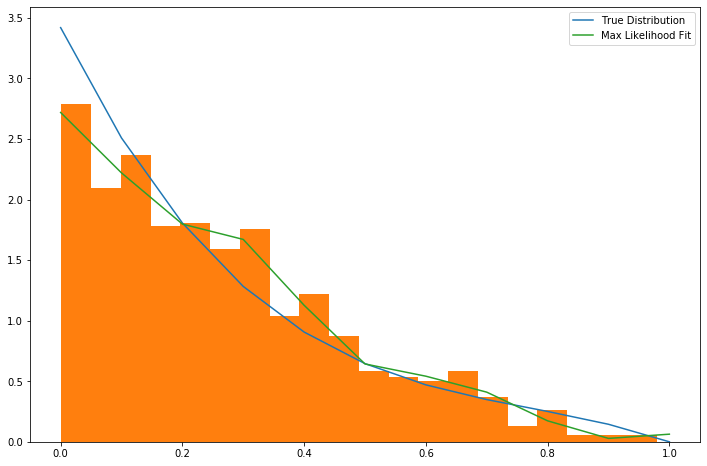

In [22]:
from scipy.stats import beta
from scipy.optimize import minimize

#z = np.concatenate([beta(15,37).rvs(200), beta(40,15).rvs(50)])
z = np.concatenate([beta(1,4).rvs(300*2), beta(3,2.5).rvs(85*2)])

plt.plot(zz, (500*beta(1,4).pdf(zz) + 85*beta(3,2).pdf(zz))/(500+85), label='True Distribution')

dz = 0.1
zz = np.arange(0, 1+dz, dz)

def fit_piecewise_linear_distribution(zz, z, tol=1e-5, maxiter=15000, reg=1e-9):
    def objective(q):
        p = PiecewiseLinearKDE(zz, q)
        return -1*np.log(p(z)+reg).sum() / len(z)

    def deriv(q):
        p = PiecewiseLinearKDE(zz, q)
        return -1*p.grad_q(z) @ (1.0/(p(z)+reg)) / len(z)

    result = minimize(objective, jac=deriv, x0=np.zeros(shape=(len(zz)-1,)), method='tnc', tol=1e-6, options={'maxiter': 10000})
    if result.success:
        return PiecewiseLinearKDE(zz, result.x)
    else:
        print("Error in optimization!")
        print(result)
        return PiecewiseLinearKDE(zz, result.x)
    
plk = fit_piecewise_linear_distribution(zz, z)
plt.hist(z, bins=20, density=True)
plt.plot(zz, plk(zz), label='Max Likelihood Fit')
plt.legend()
plt.show()


## Conclusion

It appears that we can reliably fit a piecewise linear distribution to a data set. Not super surprising.

# Simultaneously fitting the distribution and finding base rate

Let us now consider a model of risk scores. We have a risk score $z \in [0,1]$, with the positive class tending to have higher risk scores than the negative one.

Let's assume that at baseline, the distribution of risk scores from the negative class is given by $f_0(z) = P(Z=z|y=0)$ and that of the positive class is $f_1(z)=P(Z=z|y=1)$.

An example of this is give below:

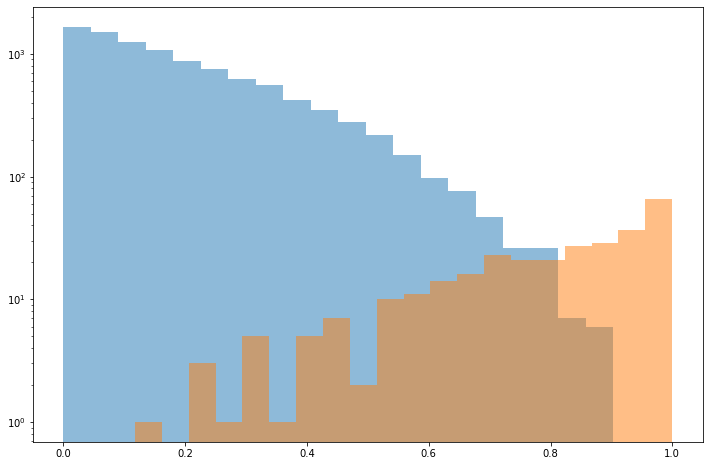

In [3]:
from scipy.stats import beta, bernoulli
import matplotlib.pyplot as plt

neg_dist = beta(1,4)
pos_dist = beta(3,0.8)

neg_z = neg_dist.rvs(10000)
pos_z = pos_dist.rvs(300)
plt.hist(neg_z, bins=20, alpha=0.5, log=True)
plt.hist(pos_z, bins=20, alpha=0.5, log=True)
plt.show()


We want to estimate a calibration curve for the risk scores, as well as identify the base rate.

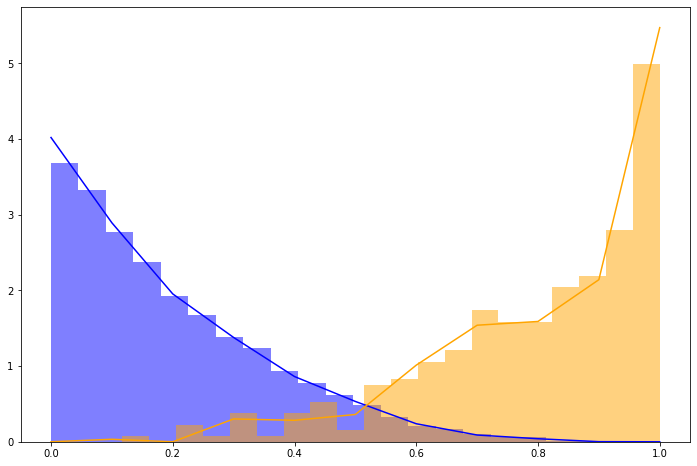

array([ -0.3288685 ,  -0.72155878,  -1.07043259,  -1.53956729,
        -2.02063169,  -2.82452637,  -3.80450156,  -4.5991754 ,
        -7.72503645, -12.59481172])

In [4]:
dz = 0.1
zz = np.arange(0,1+dz, dz)

neg_f = fit_piecewise_linear_distribution(zz, neg_z)
plt.hist(neg_z, bins=20, alpha=0.5, log=False, density=True, color='blue')
plt.plot(zz, neg_f(zz), label='negative dist', color='blue')

pos_f = fit_piecewise_linear_distribution(zz, pos_z)
plt.hist(pos_z, bins=20, alpha=0.5, log=False, density=True, color='orange')
plt.plot(zz, pos_f(zz), label='positive dist', color='orange')
plt.show()

neg_f.q

## Risky distribution shift

Let us now simulate what happens if we have a shift in the risky distribution. 

At this time our log-likelihood is given by:

$$ \ln(P(\vec{z}|\vec{q},\alpha) = \sum_{i=1}^N \ln\left[ (1-\alpha)f_0(z_i) + \alpha f_1(z_i; \vec{q}) \right]$$

Here $\alpha$ is the rate at which the positive class appears, $f_0(z)$ is the distribution if risk scores for the base class, and $f_1(z; \vec{q})$ the parameterized distribution of scores for the risky class.

Differentiating, we find:

$$ \frac{ \partial \ln(P(\vec{z}|\vec{q},\alpha)}{\partial \alpha} = \sum_{i=1}^N \frac{ f_1(z_i; \vec{q}) - f_0(z_i) }{(1-\alpha)f_0(z_i) + \alpha f_1(z_i; \vec{q}) } $$

$$ \nabla_{\vec{q}} \ln(P(\vec{z}|\vec{q},\alpha) = \sum_{i=1}^N \frac{\alpha}{(1-\alpha)f_0(z_i) + \alpha f_1(z_i; \vec{q}) } \nabla_{\vec{q}} f_1(z_i; \vec{q}) $$

In [138]:
from scipy.stats import multinomial

class MixtureDistribution:
    def __init__(self, coeff, dists):
        self.coeff = np.array(coeff)
        self.dists = dists
        assert len(coeff) == len(dists) 
        self._N = len(coeff)
        self._mix_dist = multinomial(1, coeff)
    
    def pdf(self, x):
        result = None
        for i in range(len(coeff)):
            if result is None:
                result = self.coeff[i]*self.dists[i].pdf(x)
            else:
                result += self.coeff[i]*self.dists[i].pdf(x)
        return result
    
    def rvs(self, N):
        idx = self._mix_dist.rvs(N).transpose()
        x = np.zeros(shape=(self._N, N))
        for i in range(self._N):
            x[i,:] = self.dists[i].rvs(N)
        idx_as_label = (idx * np.arange(0,self._N)[:,np.newaxis]).sum(axis=0)
        return (x*idx).sum(axis=0), idx_as_label
    
d = MixtureDistribution([0.5, 0.3, 0.2], [beta(1,4), beta(3,0.8), beta(100, 100)])
d.rvs(7)

(array([0.47136801, 0.89125953, 0.16883111, 0.01760872, 0.30653938,
        0.7732084 , 0.23041461]), array([2, 1, 0, 0, 0, 1, 0]))

         Current function value: -0.564002
         Iterations: 12
         Function evaluations: 92
         Gradient evaluations: 267
         Hessian evaluations: 0
Error in optimization!
     fun: -0.5640023985152177
     jac: array([ 1.83043946e-05, -5.05107078e-06, -5.50232003e-06,  1.99688618e-06,
        2.09505994e-06,  6.43139908e-06,  1.11672243e-05,  2.23998873e-06,
        5.10758176e-06, -6.30652251e-06, -2.02105572e-05])
 message: 'Warning: Desired error not necessarily achieved due to precision loss.'
    nfev: 92
    nhev: 0
     nit: 12
    njev: 267
  status: 2
 success: False
       x: array([ 0.02376932,  0.38520732,  0.43568212, -0.05683884,  0.09990649,
        0.142085  ,  0.61431764,  2.22173435,  3.15319907,  2.94503888,
        2.70243808])


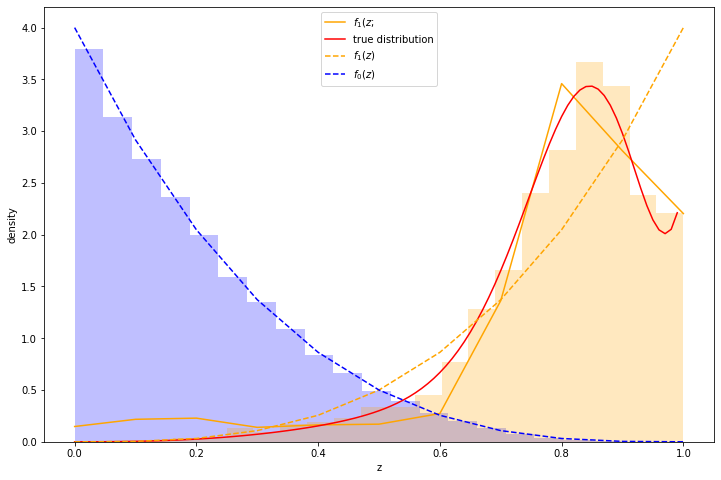

Measured alpha: 0.023769319766356267
True alpha: 0.0234375


In [139]:
from scipy.stats import beta
from scipy.optimize import minimize

neg_dist = beta(1,4)
pos_dist = beta(3,0.8)

N_neg = 50000
N_pos = 600
N_pos2 = 600

dst = MixtureDistribution( [50000/51200.0, 600/51200.0, 600/51200.0], [neg_dist, beta(3.5,0.9), beta(16,4)])

z, y = dst.rvs(51200)
y = np.minimum(y, 1)  # the labels 1 and 2 both correspond to positive

dz = 0.1
zz = np.arange(0, 1+dz, dz)

def __param_to_alpha(a, alpha_max=0.1):
    return np.maximum(np.minimum(a,1), 0)

prior_reg = 1e-3
prior_pow = 2

def regularize(p, base_pos_dist, neg_dist):
    x = p(zz) - base_pos_dist(zz)
    jap_x = np.sqrt(1+x*x) - 1
    return prior_reg*np.power(jap_x, prior_pow) @ neg_dist(zz)

def grad_regularize(p, base_pos_dist, neg_dist):
    x = p(zz) - base_pos_dist(zz)
    jap_x = np.sqrt(1+x*x)-1
    d_jap_x = x/np.sqrt(1+x*x)
    return p.grad_q(zz) @ (prior_reg*prior_pow*np.power(jap_x, prior_pow-1) * neg_dist(zz) * jap_x)

def fit_and_calibrate(zz, z, neg_dist, base_pos_dist, tol=1e-5, maxiter=15000, reg=1e-8):
    def objective(q):
        alpha = __param_to_alpha(q[0])
        p = PiecewiseLinearKDE(zz, q[1:])
        result = -1*np.log((1-alpha)*neg_dist(z) + alpha*p(z)).sum() / len(z) + regularize(p, base_pos_dist, neg_dist)
        return result

    def deriv(q):
        alpha = __param_to_alpha(q[0])
        p = PiecewiseLinearKDE(zz, q[1:])
        denom = ((1-alpha)*neg_dist(z)+alpha*p(z))
        grad_alpha = -1*((p(z) - neg_dist(z)) / denom).sum() / len(z)
        grad_q = -1*(alpha * p.grad_q(z) @ (1.0/denom)) / len(z)
        grad_q += grad_regularize(p, base_pos_dist, neg_dist)
        
        result = np.concatenate([[grad_alpha], grad_q])
        return result
        
    
    x0 = np.ones(shape=(len(zz),))
    x0[0] = 0.05
    x0[1:] = base_pos_dist(zz[1:])
    result = minimize(objective, x0=x0, jac=deriv, method='newton-cg', tol=1e-7, options={'maxiter': 10000, 'disp': True})
    if result.success:
        print(result)
        return (__param_to_alpha(result.x[0]), PiecewiseLinearKDE(zz, result.x[1:]))
    else:
        print("Error in optimization!")
        print(result)
        return (__param_to_alpha(result.x[0]), PiecewiseLinearKDE(zz, result.x[1:]))

bpd = beta(4,1).pdf
alpha, plk = fit_and_calibrate(zz, z, neg_dist.pdf, base_pos_dist=bpd)

plt.hist(z2_neg_z, bins=20, alpha=0.25, color='blue', density=True)
plt.hist(z2_pos_z, bins=20, alpha=0.25, color='orange', density=True)
plt.plot(zz, plk(zz), color='orange', label='$f_1(z; \vec{q})$')
zzz = np.arange(0,1,0.01)
plt.plot(zzz, (N_pos*N_pos_dist1.pdf(zzz)+ N_pos2*N_pos_dist2.pdf(zzz)) / (N_pos+N_pos2), 'r-', color='red', label='true distribution')
plt.plot(zz, bpd(zz), '--',  color='orange', label='$f_1(z)$')
plt.plot(zz, neg_dist.pdf(zz), '--', color='blue', label='$f_0(z)$')
plt.legend()
plt.xlabel('z')
plt.ylabel('density')
plt.show()
print("Measured alpha: " + str(alpha))
print("True alpha: " + str(len(z2_pos_z)/len(z)))


Let us now compute calibration curves based on this.

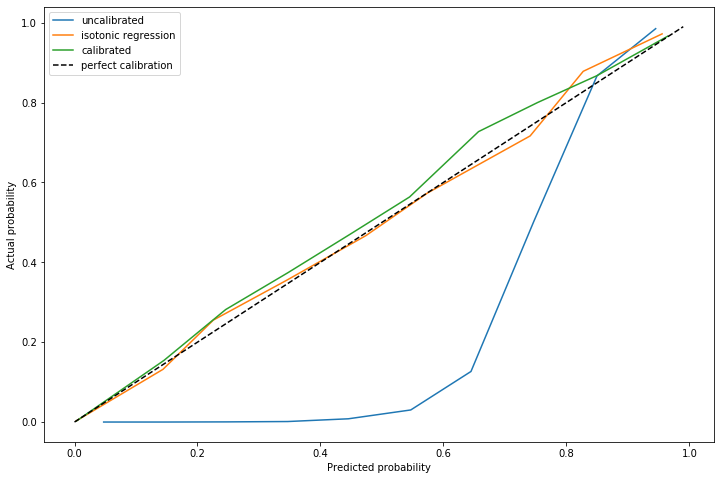

In [140]:
from sklearn.calibration import calibration_curve

z, y = dst.rvs(51200)
y = np.minimum(y, 1) 

def fixed_calibration_curve(neg_dist, pos_dist, alpha):
    z_grid = np.arange(0,1,0.01)
    calibrated = alpha*pos_dist(z_grid)/((1-alpha)*neg_dist(z_grid)+alpha*pos_dist(z_grid))
    calibrated_cum_max = np.maximum.accumulate(calibrated)

    def _result(z):
        #return alpha*pos_dist(z)/((1-alpha)*neg_dist(z)+alpha*pos_dist(z))
        return np.interp(z, z_grid, calibrated_cum_max)
    return _result

cc = fixed_calibration_curve(neg_dist.pdf, plk, alpha)

base_calibrator = IsotonicRegression(increasing=True, out_of_bounds='clip').fit(z, y)

prob_true_first, prob_pred_first = calibration_curve(y, z, n_bins=10)

plt.plot(prob_pred_first, prob_true_first, label='uncalibrated')

prob_true_isotonic, prob_pred_isotonic = calibration_curve(y[::2], base_calibrator.predict(z[::2]), n_bins=10)
plt.plot(prob_pred_isotonic, prob_true_isotonic, label='isotonic regression')

prob_true_fixed, prob_pred_fixed = calibration_curve(y, cc(z), n_bins=10)
plt.plot(prob_pred_fixed, prob_true_fixed, label='calibrated')
plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), 'k--', label='perfect calibration')
plt.xlabel("Predicted probability")
plt.ylabel("Actual probability")
plt.legend()
plt.show()


If we choose a different distribution, and a different alpha, the isotonic calibration stops being very good.

However the new dynamically calculated calibration curve still fits nicely.

         Current function value: -0.594894
         Iterations: 13
         Function evaluations: 44
         Gradient evaluations: 189
         Hessian evaluations: 0
Error in optimization!
     fun: -0.5948936891523362
     jac: array([-2.37556514e-04, -1.38983371e-07, -1.68297164e-07,  3.49000709e-07,
       -8.35752634e-06, -1.77370186e-06,  3.46278326e-06,  1.99761826e-06,
       -5.58006616e-06,  2.11654147e-06, -2.19904969e-06])
 message: 'Warning: Desired error not necessarily achieved due to precision loss.'
    nfev: 44
    nhev: 0
     nit: 13
    njev: 189
  status: 2
 success: False
       x: array([0.01040117, 0.02343432, 0.06230398, 0.05032915, 1.15724951,
       0.78349196, 0.49277173, 2.05436018, 2.89945864, 2.82799268,
       3.69271965])
Fitted alpha = 0.010401169279549205
Actual alpha = 0.010880316518298714


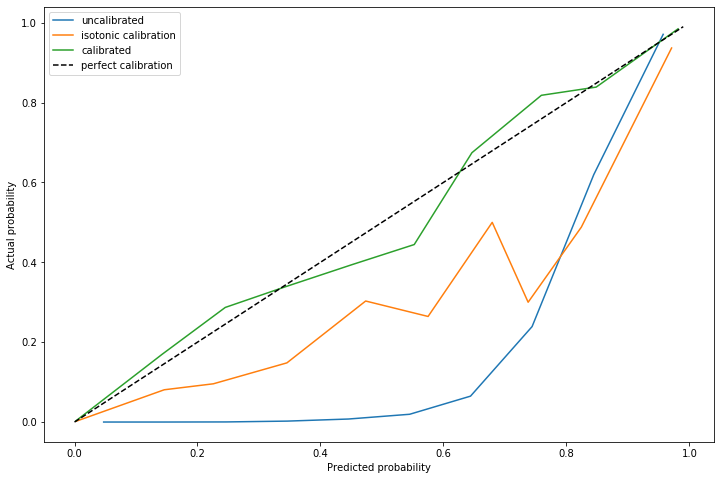

In [143]:
dst2 = MixtureDistribution( [50000/50550.0, 550/50550.0], [neg_dist, beta(3.5,0.9)])

z2, y2 = dst2.rvs(50550)
y2 = np.minimum(y2, 1)

alpha, plk = fit_and_calibrate(zz, z2, neg_dist.pdf, base_pos_dist=bpd)
print("Fitted alpha = " + str(alpha))
print("Actual alpha = " + str(N_bad_new/len(z2)))

cal_curve = fixed_calibration_curve(neg_dist.pdf, plk, alpha)


prob_true, prob_pred = calibration_curve(y2, z2, n_bins=10)
plt.plot(prob_pred, prob_true, label='uncalibrated')

prob_true_fixed, prob_pred_fixed = calibration_curve(y2, base_calibrator.predict(z2), n_bins=10)
plt.plot(prob_pred_fixed,prob_true_fixed, label='isotonic calibration')

prob_true_fixed, prob_pred_fixed = calibration_curve(y2, cal_curve(z2), n_bins=10)
plt.plot(prob_pred_fixed, prob_true_fixed, label='calibrated')

plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), 'k--', label='perfect calibration')
plt.xlabel("Predicted probability")
plt.ylabel("Actual probability")
plt.legend()
plt.show()

### Evaluating by several metrics

Lets now evaluate the dynamic vs static calibration via several metrics. Lets also add in another batch with yet another different distribution. 

In [151]:
from sklearn.metrics import roc_auc_score, brier_score_loss, average_precision_score, f1_score
from sklearn.isotonic import IsotonicRegression

dst3 = MixtureDistribution( [48000/50000.0, 1500/50000.0, 500/50000], [neg_dist, beta(4.5,0.95), beta(14,5)])
z3, y3 = dst3.rvs(50550)
y3 = np.minimum(y3, 1)
alpha3, plk3 = fit_and_calibrate(zz, z3, neg_dist.pdf, base_pos_dist=bpd)
cal_curve3 = fixed_calibration_curve(neg_dist.pdf, plk3, alpha3)


y_full = np.concatenate([y2, y3])
z_dynamic_cal = np.concatenate([cal_curve(z2), cal_curve3(z3)])
z_isotonic = base_calibrator.predict(np.concatenate([z2, z3]))

def bayes_cost(y_true, y_pred, threshold=0.40):
    assert (len(y_true) == len(y_pred))
    fp_cost=1.0/(1-threshold)
    fn_cost=1.0/threshold
    total_cost = fp_cost*(1-y_true[np.where(y_pred > threshold)]).sum() + fn_cost*(y_true[np.where(y_pred <= threshold)]).sum()
    N_affected = len(y_true[np.where(y_pred > threshold)])# + len(y_true[np.where(y_pred <= threshold)])
    return (total_cost / len(y_true)), N_affected

for scorer in [roc_auc_score, brier_score_loss, average_precision_score, bayes_cost]:
    print(str(scorer))
    print("Uncalibrated:" + str(scorer(y_full, np.concatenate([z2, z3]))))
    print("Pre-calibrated: " + str(scorer(y_full, z_isotonic)))
    print("Calibrated: " + str(scorer(y_full, z_dynamic_cal)))
    print()


         Current function value: -0.511443
         Iterations: 10
         Function evaluations: 63
         Gradient evaluations: 291
         Hessian evaluations: 0
Error in optimization!
     fun: -0.5114426217214136
     jac: array([-1.42561160e-03, -1.31123391e-06, -1.62292503e-07, -1.44979503e-05,
        1.04003618e-05, -6.05588442e-06, -9.86312143e-06,  1.30972868e-05,
        5.07993480e-05, -5.39990235e-05, -1.98425522e-05])
 message: 'Warning: Desired error not necessarily achieved due to precision loss.'
    nfev: 63
    nhev: 0
     nit: 10
    njev: 291
  status: 2
 success: False
       x: array([ 0.0446493 ,  0.26776694,  0.15681578,  1.20379473, -0.33896584,
        0.9928081 ,  1.37556949,  2.19367195,  2.82503454,  2.67849089,
        3.08612513])
<function roc_auc_score at 0x0000020EB63109D8>
Uncalibrated:0.9898019131300531
Pre-calibrated: 0.9894771278627432
Calibrated: 0.9864628575329805

<function brier_score_loss at 0x0000020EB62E4B88>
Uncalibrated:0.06636789230

Since the Bayes cost is the thing we are most interested in, lets evaluate the Bayes cost of different calibrations at a variety of different thresholds.

C:\Users\stucc\AppData\Local\conda\conda\envs\ibapi\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\stucc\AppData\Local\conda\conda\envs\ibapi\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


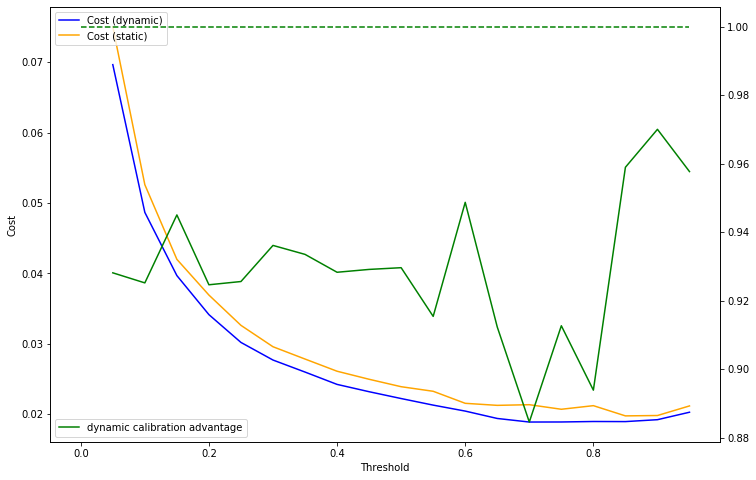

In [159]:
thresholds = np.arange(0,1,0.05)
n_affected_fixed = np.zeros(shape=thresholds.shape)
bayes_cost_fixed = np.zeros(shape=thresholds.shape)

n_affected_pre = np.zeros(shape=thresholds.shape)
bayes_cost_pre = np.zeros(shape=thresholds.shape)

for idx, t in enumerate(thresholds):
    cost, n = bayes_cost(y_full, z_dynamic_cal, threshold=t)
    n_affected_fixed[idx] = n
    bayes_cost_fixed[idx] = cost

    cost, n = bayes_cost(y_full, z_isotonic, threshold=t)
    n_affected_pre[idx] = n
    bayes_cost_pre[idx] = cost    
    
fig, ax1 = plt.subplots()
ax1.plot(thresholds, bayes_cost_fixed, color='blue', label='Cost (dynamic)')
ax1.plot(thresholds, bayes_cost_pre, color='orange', label='Cost (static)')
ax1.set_ylabel("Cost")
ax1.set_xlabel("Threshold")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(thresholds, bayes_cost_fixed / bayes_cost_pre, color='green', label='dynamic calibration advantage')
ax2.plot(thresholds, np.ones(shape=thresholds.shape), '--', color='green')
#ax2.semilogy(thresholds, n_affected_fixed / len(z_fixed), '--', color='blue', label='% affected (dynamic)')
#ax2.semilogy(thresholds, n_affected_pre / len(z_fixed), '--', color='orange', label='% affected (static)')
#ax2.set_ylabel("% of users")
ax2.legend(loc='lower left')
plt.legend()
plt.show()
    


As can be seen from the graph, there is always an advantage to dynamic calibration. The advantage is basically proportional to how many cases fall in the region where the calibration curves differ significantly.

## Comparison to fits of $\alpha$ only

The existing versions in the literature tend to assume $\alpha$ varies, but do not allow variation in $f_1(z)$.

I will now do a comparison to that method.

In [165]:

def fit_and_calibrate_only_alpha(zz, z, neg_dist, base_pos_dist, tol=1e-5, maxiter=15000, reg=1e-8):
    def objective(q):
        alpha = q[0]
        result = -1*np.log((1-alpha)*neg_dist(z) + alpha*base_pos_dist(z)).sum() / len(z)
        return result

    def deriv(q):
        alpha = __param_to_alpha(q[0])
        denom = ((1-alpha)*neg_dist(z)+alpha*base_pos_dist(z))
        grad_alpha = -1*((base_pos_dist(z) - neg_dist(z)) / denom).sum() / len(z)
        
        result = np.array([grad_alpha])
        return result
        
    
    x0 = np.ones(shape=(1,))
    x0[0] = 0.05
    result = minimize(objective, x0=x0, jac=deriv, method='newton-cg', tol=1e-7, options={'maxiter': 10000, 'disp': True})
    if result.success:
        print(result)
        return __param_to_alpha(result.x[0])
    else:
        print("Error in optimization!")
        print(result)
        return __param_to_alpha(result.x[0])
    


In [194]:
from scipy.stats import beta
from scipy.optimize import minimize

neg_dist = beta(1,4)
pos_dist = beta(3,0.8)

N_neg = 50000
N_pos = 600
N_pos2 = 600

dst = MixtureDistribution( [50000/51200.0, 600/51200.0, 600/51200.0], [neg_dist, beta(3.5,0.9), beta(14,4)])

z, y = dst.rvs(51200)
y = np.minimum(y, 1)  # the labels 1 and 2 both correspond to positive

dz = 0.1
zz = np.arange(0, 1+dz, dz)

def __param_to_alpha(a, alpha_max=0.1):
    return np.maximum(np.minimum(a,1), 0)

prior_reg = 1e-3
prior_pow = 2

alpha_only = fit_and_calibrate_only_alpha(zz, z, neg_dist.pdf, bpd)

alpha, plk = fit_and_calibrate(zz, z, neg_dist.pdf, base_pos_dist=bpd)

true_alpha = dst.coeff[1:].sum()

# plt.hist(z2_neg_z, bins=20, alpha=0.25, color='blue', density=True)
# plt.hist(z2_pos_z, bins=20, alpha=0.25, color='orange', density=True)
# plt.plot(zz, plk(zz), color='orange', label='$f_1(z; \vec{q})$')
# zzz = np.arange(0,1,0.01)
# plt.plot(zzz, (N_pos*N_pos_dist1.pdf(zzz)+ N_pos2*N_pos_dist2.pdf(zzz)) / (N_pos+N_pos2), 'r-', color='red', label='true distribution')
# plt.plot(zz, bpd(zz), '--',  color='orange', label='$f_1(z)$')
# plt.plot(zz, neg_dist.pdf(zz), '--', color='blue', label='$f_0(z)$')
# plt.legend()
# plt.xlabel('z')
# plt.ylabel('density')
# plt.show()
print("Measured alpha: " + str(alpha))
print("True alpha: " + str(len(z2_pos_z)/len(z)))


(alpha, alpha_only, y.mean())

C:\Users\stucc\AppData\Local\conda\conda\envs\ibapi\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


Optimization terminated successfully.
         Current function value: -0.560975
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 23
         Hessian evaluations: 0
     fun: -0.5609750851539254
     jac: array([-1.44673496e-09])
 message: 'Optimization terminated successfully.'
    nfev: 9
    nhev: 0
     nit: 5
    njev: 23
  status: 0
 success: True
       x: array([0.02131995])
         Current function value: -0.561899
         Iterations: 17
         Function evaluations: 85
         Gradient evaluations: 544
         Hessian evaluations: 0
Error in optimization!
     fun: -0.5618994954650539
     jac: array([-1.99248876e-04,  1.41607991e-07, -2.09963380e-06, -8.57378675e-06,
        5.24966439e-06, -2.37031255e-06,  1.14951124e-05, -2.56072791e-06,
        6.04877997e-06, -1.26851658e-05, -2.49383877e-06])
 message: 'Warning: Desired error not necessarily achieved due to precision loss.'
    nfev: 85
    nhev: 0
     nit: 17
    njev: 544
 

(0.02488129987867693, 0.0213199539710047, 0.022890625)

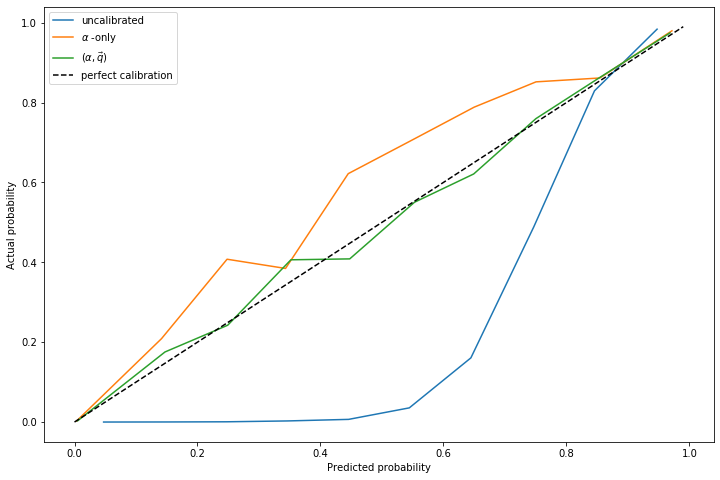

In [195]:
from sklearn.calibration import calibration_curve

z, y = dst.rvs(51200)
y = np.minimum(y, 1) 

def fixed_calibration_curve(neg_dist, pos_dist, alpha):
    z_grid = np.arange(0,1,0.01)
    calibrated = alpha*pos_dist(z_grid)/((1-alpha)*neg_dist(z_grid)+alpha*pos_dist(z_grid))
    calibrated_cum_max = np.maximum.accumulate(calibrated)

    def _result(z):
        #return alpha*pos_dist(z)/((1-alpha)*neg_dist(z)+alpha*pos_dist(z))
        return np.interp(z, z_grid, calibrated_cum_max)
    return _result

cc = fixed_calibration_curve(neg_dist.pdf, plk, alpha)

cc2 = fixed_calibration_curve(neg_dist.pdf, bpd, alpha_only)

prob_true_first, prob_pred_first = calibration_curve(y, z, n_bins=10)

plt.plot(prob_pred_first, prob_true_first, label='uncalibrated')

prob_true_isotonic, prob_pred_isotonic = calibration_curve(y[::2], cc2(z[::2]), n_bins=10)
plt.plot(prob_pred_isotonic, prob_true_isotonic, label='$\\alpha$ -only')

prob_true_fixed, prob_pred_fixed = calibration_curve(y, cc(z), n_bins=10)
plt.plot(prob_pred_fixed, prob_true_fixed, label='$(\\alpha, \\vec{q})$')
plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), 'k--', label='perfect calibration')


plt.xlabel("Predicted probability")
plt.ylabel("Actual probability")
plt.legend()
plt.show()
